In [27]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import chi2
import os
import matplotlib as mpl


In [28]:
global_rng = np.random.default_rng(50)
out_dir = 'output_ms_toolbox_fig_1_2_v2'
os.makedirs(out_dir, exist_ok=True)


mpl.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans'],

    'mathtext.fontset': 'custom',
    'mathtext.rm': 'DejaVu Sans',
    'mathtext.it': 'DejaVu Sans:oblique',
    'mathtext.bf': 'DejaVu Sans:bold',

    'pdf.fonttype': 42,
    'ps.fonttype': 42,
})

In [29]:
def construct_cov_mtx(var_x: float, var_y: float, rho: float) -> np.ndarray:
	# ---- Basic input checks ----
	if var_x < 0 or var_y < 0:
		raise ValueError("var_x and var_y must be non-negative.")
	if not (-1.0 <= rho <= 1.0):
		raise ValueError("rho must be between -1 and 1.")

	sx = np.sqrt(max(var_x, 0.0))
	sy = np.sqrt(max(var_y, 0.0))

	# ---- Build covariance matrix from variances + correlation ----
	cov_xy = rho * sx * sy
	Sigma = np.array([[var_x, cov_xy],
					  [cov_xy, var_y]], dtype=float)
	return Sigma


def simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points, rng=global_rng):
	if rng is None:
		rng = np.random.default_rng()
	cov = construct_cov_mtx(var_x, var_y, rho)
	data = rng.multivariate_normal([mu_x, mu_y], cov, size=n_points)
	x, y = data[:, 0], data[:, 1]
	return x, y

def add_gaussian_noise(x, y, noise_var, m=0, rng=global_rng):
	if rng is None:
		rng = np.random.default_rng()
	sd = np.sqrt(noise_var * m)
	x_noisy = x + rng.normal(0, sd, size=x.shape)
	y_noisy = y + rng.normal(0, sd, size=y.shape)
	return x_noisy, y_noisy


def fisher_r_to_z(r, clip=1e-12):
    """
    Fisher r-to-z transform.
    Clips r to (-1, 1) to avoid infs at exactly ±1.
    Works with scalars or numpy arrays.
    """
    r = np.asarray(r, dtype=float)
    r = np.clip(r, -1 + clip, 1 - clip)
    return np.arctanh(r)  # == 0.5 * np.log((1+r)/(1-r))


In [30]:
def tls_regression(x_vals, y_vals):
	"""Compute Total Least Squares (orthogonal) regression slope and intercept."""
	x_mean, y_mean = x_vals.mean(), y_vals.mean()
	Sxx = np.sum((x_vals - x_mean)**2)
	Syy = np.sum((y_vals - y_mean)**2)
	Sxy = np.sum((x_vals - x_mean)*(y_vals - y_mean))
	# TLS slope formula
	slope = (Syy - Sxx + np.sqrt((Sxx - Syy)**2 + 4*Sxy**2)) / (2*Sxy)
	intercept = y_mean - slope * x_mean
	return slope, intercept

In [31]:
def round_to_half(x):
	return round(x * 2) / 2

In [32]:
def plot_population_covariance(
	mu_x, mu_y, var_x, var_y, rho, ax=None,
	m_scaling=0.95,
	xlim=(-0.75, 1.25),
	ylim=(2.25, 4.25),
	xtick_step=0.5,
	ytick_step=0.5,
	xlabel='Variable X',
	ylabel='Variable Y',
	annotate=True,
	n_points=1000,
	show_eigenvectors=False,
	show_best_fit=False,
	eigen_scale="sd",     # "sd" uses sqrt(eigenvalue); "ellipse" uses chisquare_val*sqrt(eigenvalue)
	# line_label="Best-fit (major axis)"
):
	"""
	Plot the covariance ellipse for a 2D Gaussian defined by (mu_x, mu_y, var_x, var_y, rho).

	m_scaling:
		Probability mass inside ellipse for a 2D Gaussian (e.g., 0.68 or 0.95).
		chisquare_val = sqrt(chi2.ppf(m_scaling, df=2)).
	"""

	Sigma = construct_cov_mtx(var_x, var_y, rho)

	# ---- Eigen-decomposition ----
	# evals ascending: [small, large]
	evals, evecs = np.linalg.eigh(Sigma)
	lam_small, lam_large = float(evals[0]), float(evals[1])
	vec_small, vec_large = evecs[:, 0], evecs[:, 1]  # columns

	# ---- Scaling for ellipse probability mass ----
	chisquare_val = float(np.sqrt(chi2.ppf(m_scaling, df=2)))

	# Semi-axis lengths for ellipse
	a = chisquare_val * np.sqrt(max(lam_large, 0.0))  # major
	b = chisquare_val * np.sqrt(max(lam_small, 0.0))  # minor

	# ---- Parametric ellipse (local coords) ----
	theta = np.linspace(0.0, 2.0 * np.pi, n_points)
	ellipse_local = np.column_stack([a * np.cos(theta),
									 b * np.sin(theta)])  # (n_points, 2)

	# ---- Rotate ellipse using eigenvector basis ----
	B = np.column_stack([vec_large, vec_small])   # (2,2) major then minor
	ellipse_world = ellipse_local @ B.T

	# ---- Translate to mean ----
	ellipse_world[:, 0] += mu_x
	ellipse_world[:, 1] += mu_y


	# ---- Plot ----
	if ax is None:
		fig, ax = plt.subplots(figsize=(6, 6))
	else:
		fig = ax.figure

	ax.plot(ellipse_world[:, 0], ellipse_world[:, 1], linewidth=2)

	# ax.scatter([mu_x], [mu_y], s=40)

	# ---- Annotate rho ----
	if annotate:
		ax.text(0.05, 0.97, rf'$\rho = {rho:.2f}$',
				transform=ax.transAxes, va='top',
				fontsize=22, color='black')

	# ---- Plot eigenvectors (arrows) ----
	if show_eigenvectors:
		if eigen_scale not in ("sd", "ellipse"):
			raise ValueError('eigen_scale must be "sd" or "ellipse".')

		scale_factor = 1.0 if eigen_scale == "sd" else chisquare_val

		# Arrow lengths: scale * sqrt(eigenvalue)
		L_major = scale_factor * np.sqrt(max(lam_large, 0.0))
		L_minor = scale_factor * np.sqrt(max(lam_small, 0.0))

		# Major axis arrow
		ax.quiver(mu_x, mu_y,
				  vec_large[0] * L_major, vec_large[1] * L_major,
				  angles='xy', scale_units='xy', scale=1,
				  linewidth=2)

		# Minor axis arrow
		ax.quiver(mu_x, mu_y,
				  vec_small[0] * L_minor, vec_small[1] * L_minor,
				  angles='xy', scale_units='xy', scale=1,
				  linewidth=2)

	# ---- Best-fit line along major eigenvector (PCA/TLS direction) ----
	slope, intercept = None, None
	if show_best_fit:
		vx, vy = float(vec_large[0]), float(vec_large[1])

		# Handle near-vertical major axis
		if np.isclose(vx, 0.0):
			# x = mu_x
			ax.plot([mu_x, mu_x], list(ylim), linestyle='-', color='slategrey', linewidth=2)
			slope = np.inf
			intercept = np.nan
		else:
			slope = vy / vx
			intercept = mu_y - slope * mu_x

			xs = np.array([xlim[0], xlim[1]], dtype=float)
			ys = slope * xs + intercept
			ax.plot(xs, ys, linestyle='-', color='slategrey', linewidth=2)

		ax.legend(fontsize=16, frameon=False)

	# ---- Axes formatting (your style) ----
	ax.set_xlim(*xlim)
	ax.set_ylim(*ylim)
	ax.set_xlabel(xlabel, fontsize=22)
	ax.set_ylabel(ylabel, fontsize=22)

	ax.set_xticks(np.arange(xlim[0], xlim[1] + 1e-9, xtick_step))
	ax.set_yticks(np.arange(ylim[0], ylim[1] + 1e-9, ytick_step))
	ax.set_xticks(np.arange(round_to_half(xlim[0]), round_to_half(xlim[1]) + 1e-9, xtick_step))
	ax.set_yticks(np.arange(round_to_half(ylim[0]), round_to_half(ylim[1]) + 1e-9, ytick_step))

	ax.tick_params(axis='both', which='major', labelsize=22)

	return fig, ax, slope, intercept


In [33]:
def plot_population_density_map(
	mu_x, mu_y, var_x, var_y, rho, ax=None,
	xlim=(-0.75, 1.25),
	ylim=(2.25, 4.25),
	xtick_step=0.5,
	ytick_step=0.5,
	xlabel='Variable X',
	ylabel='Variable Y',
	annotate=True,
	grid_n=300,            # resolution of the density grid (grid_n x grid_n)
	levels=None,           # optional contour levels
	show_contours=False,   # optionally overlay contour lines
):
	"""
	Plot a 2D Gaussian population as a density heatmap (highest density near the mean).
	"""

	# ---- Build covariance matrix from variances + correlation ----
	Sigma = construct_cov_mtx(var_x, var_y, rho)

	# ---- Build a grid over the plotting window ----
	xs = np.linspace(xlim[0], xlim[1], grid_n)
	ys = np.linspace(ylim[0], ylim[1], grid_n)
	X, Y = np.meshgrid(xs, ys)  	# shapes: (grid_n, grid_n)
	XY = np.stack([X, Y], axis=-1)            # shape: (grid_n, grid_n, 2)

	# ---- Evaluate the bivariate normal PDF on the grid ----
	mu = np.array([mu_x, mu_y], dtype=float)
	Sigma_inv = np.linalg.inv(Sigma)
	det_Sigma = np.linalg.det(Sigma)
	if det_Sigma <= 0:
		raise ValueError("Covariance matrix must be positive definite (check variances/rho).")

	d = XY - mu                                # (grid_n, grid_n, 2)
	# Mahalanobis distance squared: (x-mu)^T Sigma^{-1} (x-mu)
	md2 = np.einsum('...i,ij,...j->...', d, Sigma_inv, d)

	norm_const = 1.0 / (2.0 * np.pi * np.sqrt(det_Sigma))
	Z = norm_const * np.exp(-0.5 * md2)        # density (PDF) on grid

	# ---- Plot ----
	if ax is None:
		fig, ax = plt.subplots(figsize=(6, 6))
	else:
		fig = ax.figure

	im = ax.imshow(
		Z,
		origin="lower",
		extent=(xlim[0], xlim[1], ylim[0], ylim[1]),
		aspect="auto",   # we'll enforce equal geometry with set_aspect below
	)

	# Optional contour overlay (nice for showing structure)
	if show_contours:
		if levels is None:
			levels = 6
		ax.contour(X, Y, Z, levels=levels, linewidths=1)

	# ---- Annotate rho ----
	if annotate:
		ax.text(0.05, 0.97, rf'$\mathit{{\rho}} = {rho:.2f}$',
				transform=ax.transAxes, va='top',
				fontsize=22, color='white')

	# ---- Axes formatting (matched to your style) ----
	ax.set_xlim(*xlim)
	ax.set_ylim(*ylim)
	ax.set_xlabel(xlabel, fontsize=22)
	ax.set_ylabel(ylabel, fontsize=22)

	ax.set_xticks(np.arange(xlim[0], xlim[1] + 1e-9, xtick_step))
	ax.set_yticks(np.arange(ylim[0], ylim[1] + 1e-9, ytick_step))
	ax.tick_params(axis='both', which='major', labelsize=22)

	# Use equal axis scaling so density doesn't look squashed
	ax.set_aspect("equal", adjustable="box")

	# Colorbar (optional but usually helpful for density maps)
	cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
	cbar.ax.tick_params(labelsize=16)
	cbar.set_label("Population density", fontsize=16)

	return fig, ax, im


In [34]:
def plot_scatter_with_tls(
	x, y, param_legend,
	rho=None,                      # for annotation
	ax=None,
	xlim=(-0.75, 1.5),
	ylim=(2.25, 4.25),
	xtick_step=0.5,
	ytick_step=0.5,
	xlabel='Variable X',
	ylabel='Variable Y',
	point_size=50,
	alpha=0.6,
	line_n=200,
	line_label='TLS fit',
	annotate=True,
	showN_bool=False,
	eliminate_y_tick_labels=False
):
	if ax is None:
		fig, ax = plt.subplots(figsize=(6, 6))

	slope, intercept = tls_regression(x, y)
	r_value, _ = pearsonr(x, y)

	ax.scatter(x, y, s=point_size, alpha=alpha, color='royalblue')

	# Draw fitted line over the visible x-range
	x_line = np.linspace(xlim[0], xlim[1], line_n)
	ax.plot(x_line, slope * x_line + intercept, linewidth=2, label=line_label, color='slategrey')

	if annotate:
		ax.set_title(param_legend, fontsize=25, color='black', pad=15) #, pad=15
		ax.text(0.05, 0.95, rf'$r = {r_value:.2f}$',
				transform=ax.transAxes, va='top', fontsize=22, color='black')		
		if showN_bool:
			ax.text(0.05, 0.85, rf'$N = {len(x)}$',
					transform=ax.transAxes, va='top', fontsize=22, color='black')

	ax.set_xlim(*xlim)
	ax.set_ylim(*ylim)
	ax.set_xlabel(xlabel, fontsize=22)
	ax.set_ylabel(ylabel, fontsize=22)

	# ax.set_xticks(np.arange(xlim[0], xlim[1] + 1e-9, xtick_step))
	# ax.set_yticks(np.arange(ylim[0], ylim[1] + 1e-9, ytick_step))

	ax.set_xticks(np.arange(round_to_half(xlim[0]), round_to_half(xlim[1]) + 1e-9, xtick_step))
	ax.set_yticks(np.arange(round_to_half(ylim[0]), round_to_half(ylim[1]) + 1e-9, ytick_step))
	ax.set_yticklabels([]) if eliminate_y_tick_labels else None

	ax.tick_params(axis='both', which='major', labelsize=22)

	return fig, ax


In [35]:
def simulate_r_over_sweep(
	sweep_values,
	simulate_fn,   # function: (val, rng) -> (x, y)
	measure_fn,    # function: (x, y, val, rng) -> (x_meas, y_meas)
	example_datasets_points=[],
	n_traces=100,
	rng=global_rng
	):
	"""Run repeated simulations and return r traces over a swept parameter."""
	if rng is None:
		rng = np.random.default_rng()

	sweep_values = np.asarray(sweep_values)
	results = np.empty((n_traces, sweep_values.size), dtype=float)
	example_datasets = []

	for t in range(n_traces):
		for idx, val in enumerate(sweep_values):
			x, y = simulate_fn(val, rng)
			x_meas, y_meas = measure_fn(x, y, val, rng)
			r, _ = pearsonr(x_meas, y_meas)
			results[t, idx] = r
			if t == 0 and val in example_datasets_points:
				example_datasets.append((val, x_meas, y_meas))


	return results, example_datasets


In [36]:
def plot_traces_core(
    x_values,
    y_traces,
    xlabel,
    ylabel,
    y_ref=None,
    y_ref_label=None,
    xscale='log',
    x_reverse=False,
    figsize=(18, 4),
    ylim=(-0.4, 1.6),
    yticks=(0, 0.6, 1),
    xlim=None,
    fontsize=22,
    colors=('royalblue', 'lightgray'),
    alphas=(1.0, 0.7),
    lws=(3, 2),
    zorders=(3, 1),
):
    """Shared plotting/styling for trace plots."""
    fig, ax = plt.subplots(figsize=figsize)

    y_traces = np.asarray(y_traces)
    for t in range(y_traces.shape[0]):
        is_first = (t == 0)
        ax.plot(
            x_values,
            y_traces[t],
            color=colors[0] if is_first else colors[1],
            alpha=alphas[0] if is_first else alphas[1],
            linewidth=lws[0] if is_first else lws[1],
            zorder=zorders[0] if is_first else zorders[1],
        )

    if x_reverse:
        ax.invert_xaxis()

    if y_ref is not None:
        ax.axhline(y_ref, color='black', ls='--', label=y_ref_label)

    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)

    if xscale is not None:
        ax.set_xscale(xscale)

    if xlim is not None:
        ax.set_xlim(*xlim)

    ax.set_ylim(*ylim)
    ax.set_yticks(list(yticks))

    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.tick_params(axis='both', labelsize=fontsize)

    if y_ref_label is not None:
        ax.legend(frameon=False, fontsize=fontsize)

    fig.tight_layout()
    plt.show()
    return fig


def plot_traces(
    x_values,
    results,
    rho,          # kept for API compatibility (not used here)
    xlabel,
    ylabel=rf"Pearson's $r$",
    true_r=0.6,
    **style_kwargs
):
    return plot_traces_core(
        x_values=x_values,
        y_traces=results,
        xlabel=xlabel,
        ylabel=ylabel,
        y_ref=true_r,
        **style_kwargs
    )

    return fig


def plot_traces_with_z(
    x_values,
    results,
    rho,
    xlabel,
    fisher_r_to_z=fisher_r_to_z,
    true_r=0.6,
    ylim=(-0.4, 1.61),
    fontsize=22,
    **style_kwargs
):
    yticks = np.arange(min(ylim), max(ylim) + 1e-9, 0.4)

    # r plot
    fig_r = plot_traces(
        x_values=x_values,
        results=results,
        rho=rho,
        xlabel=xlabel,
        ylabel=rf"Pearson's $r$",
        true_r=true_r,
        ylim=ylim,
        yticks=yticks,
        fontsize=fontsize,
        **style_kwargs
    )

    # z plot
    results_z = fisher_r_to_z(results)
    true_z = float(fisher_r_to_z(true_r))

    fig_z = plot_traces(
        x_values=x_values,
        results=results_z,
        rho=rho,
        xlabel=xlabel,
        ylabel=rf"Fisher $z$",
        true_r=true_z,
        ylim=ylim,
        yticks=yticks,
        fontsize=fontsize,
        **style_kwargs
    )

    return fig_r, fig_z


In [37]:
def average_repeats(x, y, n_repeats, noise_var, m=1.0, rng=None):
	if rng is None:
		rng = np.random.default_rng()

	n_points = x.shape[0]
	x_rep = np.empty((n_repeats, n_points))
	y_rep = np.empty((n_repeats, n_points))

	for i in range(n_repeats):
		x_rep[i], y_rep[i] = add_gaussian_noise(x, y, noise_var=noise_var, m=m, rng=rng)

	return x_rep.mean(axis=0), y_rep.mean(axis=0)


## SAMPLING

In [38]:
mu_x = 0.38
mu_y = 3.2
var_x = 0.24**2
var_y = 0.19**2
rho = 0.6

xlim=(-0.5, 1.25)
ylim=(2.3, 4.05)

In [39]:
# plot_population_covariance(
# 	mu_x=mu_x,
# 	mu_y=mu_y,
# 	var_x=var_x,
# 	var_y=var_y,
# 	rho=rho,
# 	xlim=xlim,
# 	ylim=ylim
# 	)


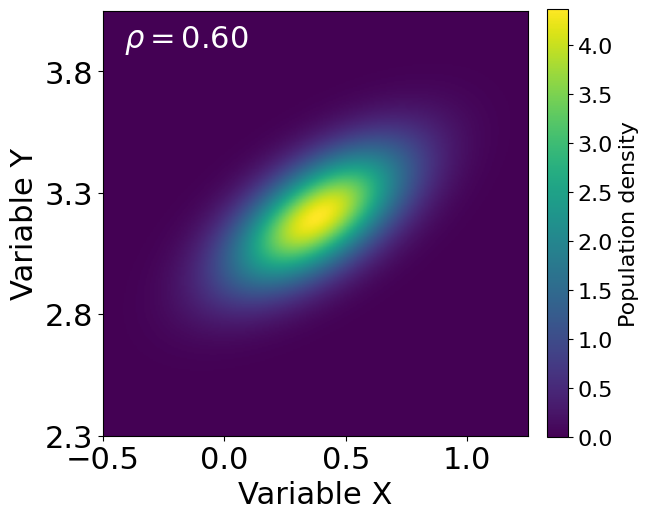

In [40]:
fig, ax, im = plot_population_density_map(
	mu_x=mu_x,
	mu_y=mu_y,
	var_x=var_x,
	var_y=var_y,
	rho=rho,
	xlim=xlim,
	ylim=ylim
)
fig.savefig(out_dir + "/Fig1A_2A_population_density_map.pdf", bbox_inches="tight")

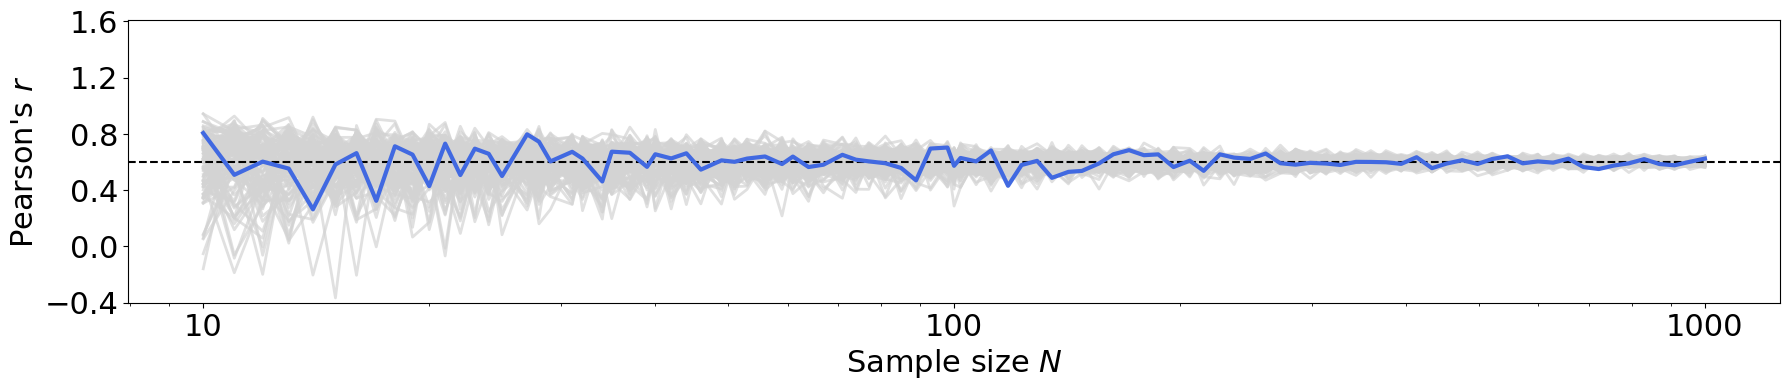

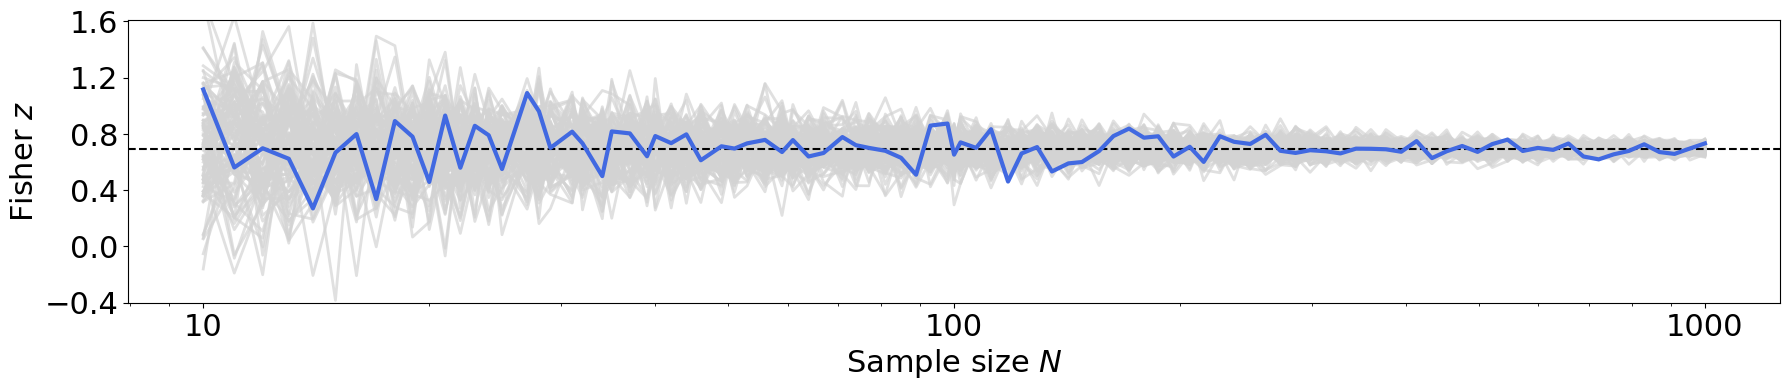

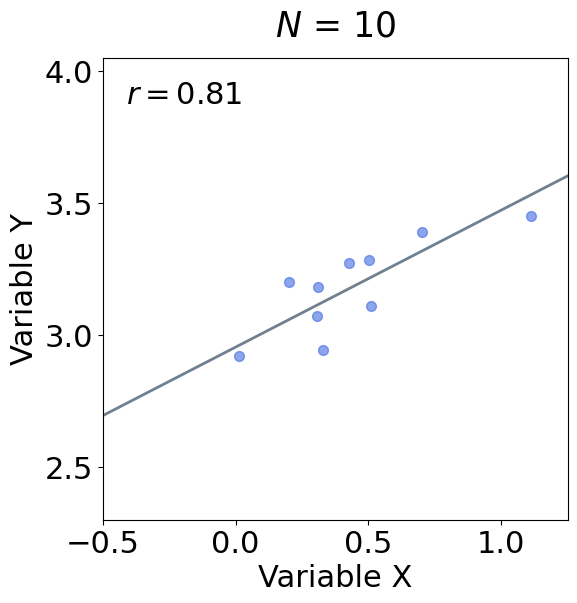

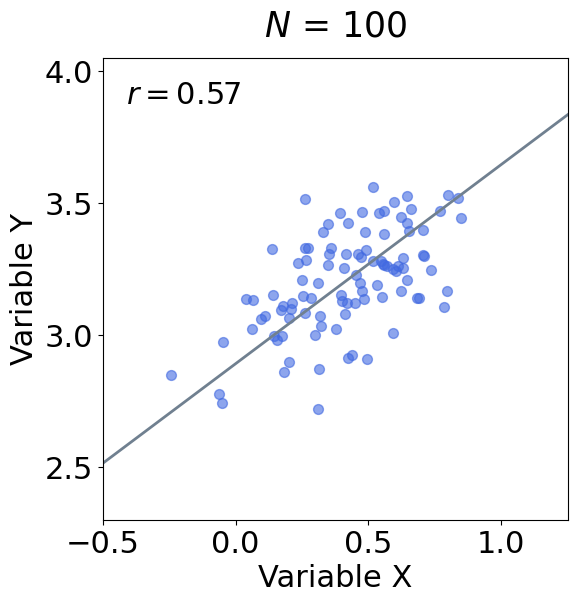

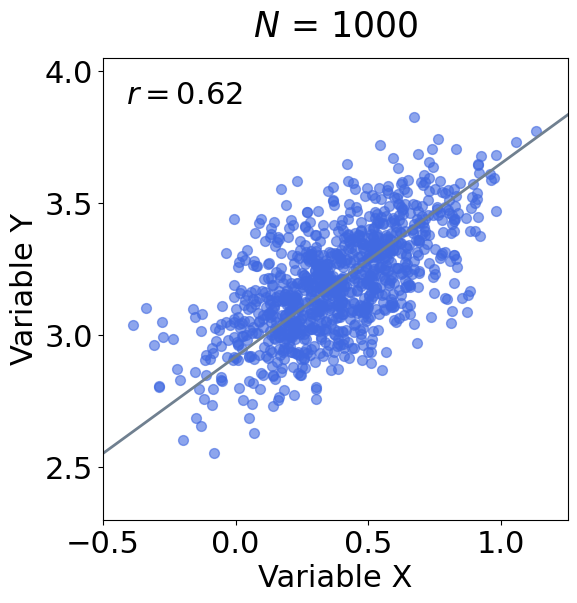

In [41]:
def simulate_by_N(N, rng):
	return simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points=int(N), rng=rng)

def measure_identity(x, y, N, rng):
	return x, y

def measure_with_noise(x, y, N, rng):
	return add_gaussian_noise(x, y, noise_var=0.06, m=1.0, rng=rng)

sample_sizes = np.logspace(1, 3, num=90).round().astype(int)
sample_sizes = np.unique(
	np.concatenate([
		np.logspace(1, 3, num=100).round().astype(int),
		[10, 100, 1000],
	])
)


results_true, example_datasets_true = simulate_r_over_sweep(sample_sizes, simulate_by_N, measure_identity,
																			example_datasets_points=[10, 100, 1000])
fig_1r, fig_1z = plot_traces_with_z(sample_sizes, results_true, rho=rho, xlabel=rf'Sample size $N$', xscale='log',fontsize=22)
fig_1r.savefig(out_dir + "/Fig1C_r_vs_N.pdf", bbox_inches="tight")
fig_1z.savefig(out_dir + "/Fig1D_z_vs_N.pdf", bbox_inches="tight")


for N, x, y in example_datasets_true:
	fig, ax = plot_scatter_with_tls(
		x, y,
		param_legend=rf'$N$ = {N}',
		rho=rho,
		xlim=xlim,
		ylim=ylim
	)
	
	plt.show()
	fig.savefig(out_dir + f"/Fig1B_scatter_N{N}.pdf", bbox_inches="tight")

# results_noisy = simulate_r_over_sweep(sample_sizes, simulate_by_N, measure_with_noise)
# plot_traces(sample_sizes, results_noisy, rho=rho, xlabel='Sample size (N)', fontsize=22)


## NOISE

In [42]:
# Parameters
# var_x, var_y, noise_var = 0.06, 0.06, 0.5


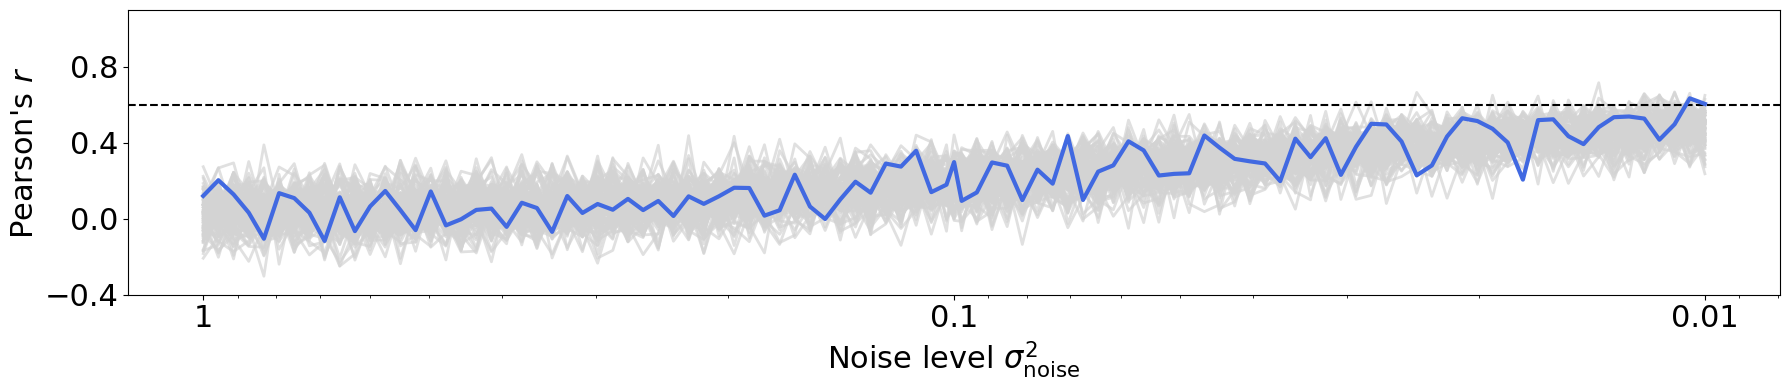

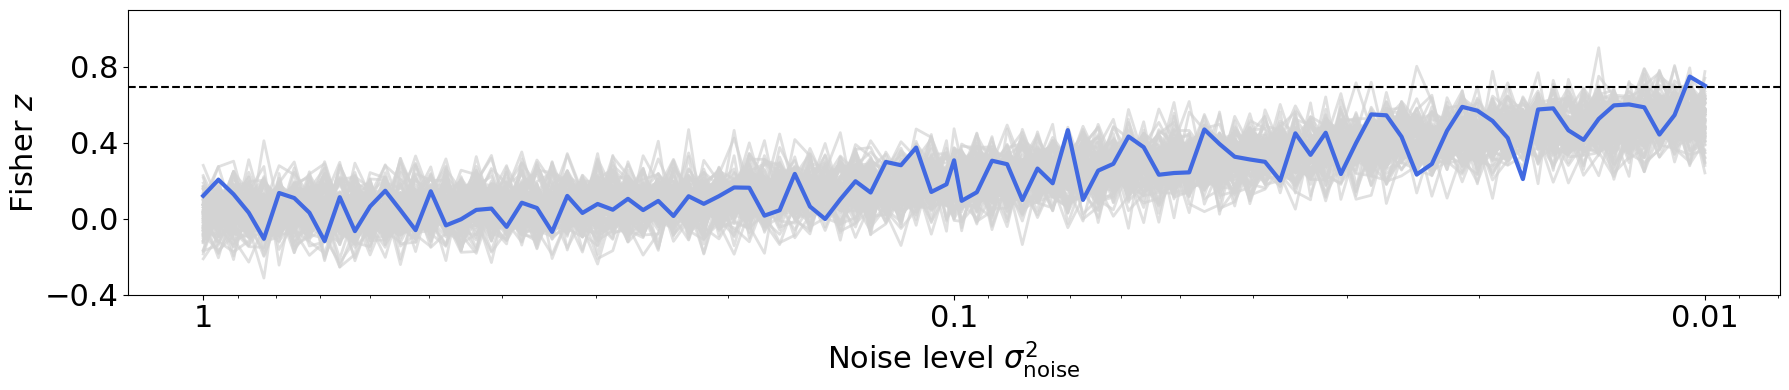

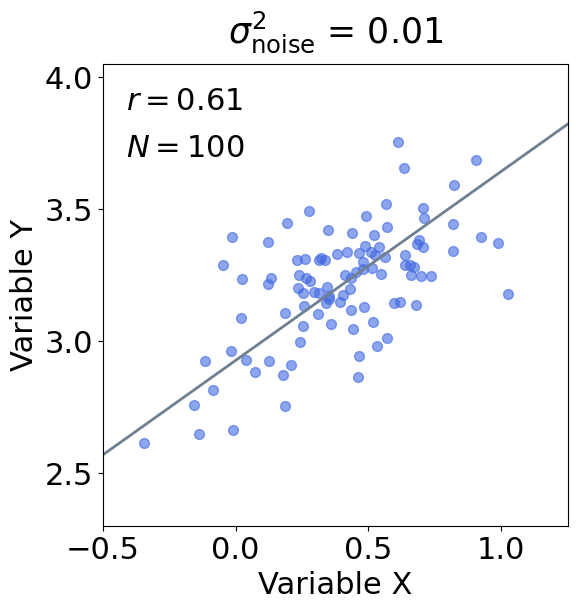

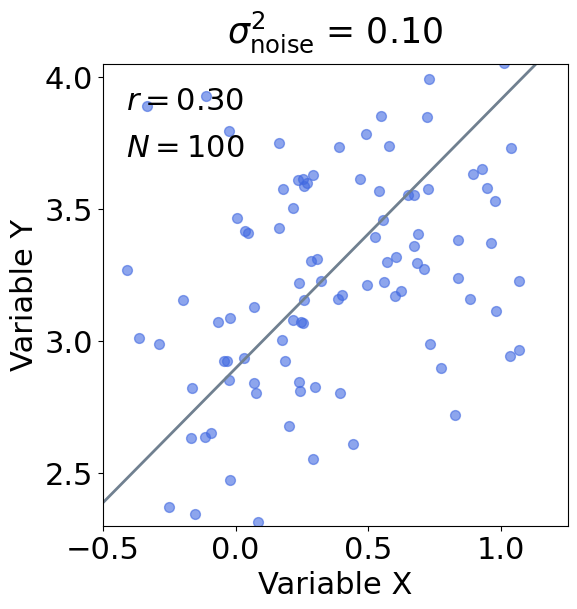

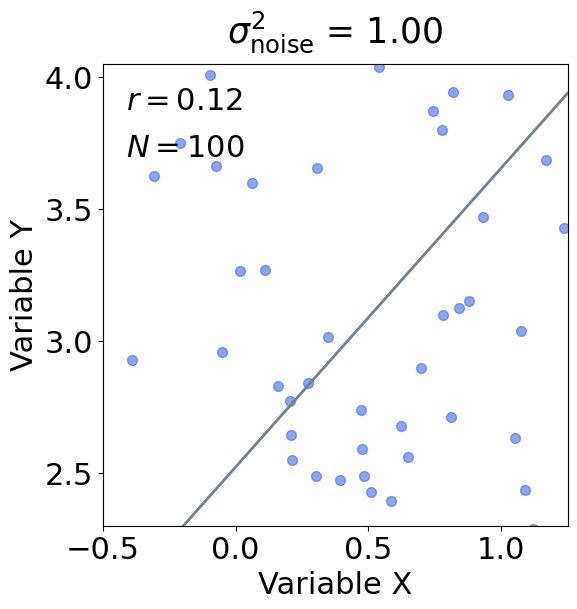

In [43]:
noise_levels = np.unique(
	np.concatenate([
		np.logspace(-2, 0, num=100),
		[0.01, 0.1, 1]
	])
)

def simulate_fixed_N(noise_level, rng):
	return simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points=100, rng=rng)

def measure_noise_sweep(x, y, noise_level, rng):
	return add_gaussian_noise(x, y, noise_var=float(noise_level), m=1.0, rng=rng)

results, example_datasets = simulate_r_over_sweep(noise_levels, simulate_fixed_N, measure_noise_sweep,
												  example_datasets_points=[0.01, 0.1, 1])
fig_2r, fig_2z = plot_traces_with_z(noise_levels, 
			results, 
			rho=rho, 
			xlabel=r'Noise level $\sigma^2_{{\mathrm{{noise}}}}$', 
			xscale='log', fontsize=22,
			x_reverse=True, 
			ylim=(-0.4, 1.1),)
fig_2r.savefig(out_dir + "/Fig2C_r_vs_noise.pdf", bbox_inches="tight")
fig_2z.savefig(out_dir + "/Fig2D_z_vs_noise.pdf", bbox_inches="tight")

for level, x, y in example_datasets:
	fig, ax = plot_scatter_with_tls(
		x, y,
		param_legend=r'$\sigma^2_{{\mathrm{{noise}}}}$ = {:.2f}'.format(level),
		rho=rho,
		xlim=xlim,
		ylim=ylim,
		showN_bool=True,
		eliminate_y_tick_labels=False,
	)
	plt.show()
	fig.savefig(out_dir + f"/Fig2B_scatter_noise{level}.pdf", bbox_inches="tight")


# MEANS

In [44]:
# Parameters
# mu_x = 0.25
# mu_y = 2.9
# var_x = 0.025
# var_y = 0.06
# rho = 0.6
noise_var = 0.1
# var_x, var_y, noise_var, rho = 0.06, 0.06, 0.1, 0.6
n_points = 60
m = 1.0

In [45]:
# plot_population_covariance(
# 	mu_x=mu_x,
# 	mu_y=mu_y,
# 	var_x=var_x,
# 	var_y=var_y,
# 	rho=rho
# )

In [46]:

# Base data once
# x, y = simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points=n_points, rng=global_rng)
# # Plot: averaged over different numbers of repeats
# for n_repeats in [1, 10, 100]:
# 	x_mean, y_mean = average_repeats(x, y, n_repeats=n_repeats, noise_var=noise_var, m=m, rng=global_rng)

# 	ax = plot_scatter_with_tls(x_mean, y_mean, param_legend=r'$N$ = {}'.format(n_repeats), rho=rho)
# 	# ax.set_title(f'{n_repeats} repeated measurements (averaged)', fontsize=18)
# 	plt.show()

In [47]:
def make_simulate_fn_thresholds(mu_x, mu_y, var_x, var_y, rho, n_points):
	"""simulate_fn(T, rng) -> (x, y). Here val=T is ignored for latent truth."""
	def simulate_fn(T, rng):
		# latent (true) observer values; same size regardless of T
		x, y = simulate_xy(mu_x, mu_y, var_x, var_y, rho, n_points=n_points, rng=rng)
		return x, y
	return simulate_fn


def make_measure_fn_thresholds(noise_var, m=1.0):
	"""measure_fn(x, y, T, rng) -> (x_avg, y_avg) by averaging T noisy repeats."""
	def measure_fn(x, y, T, rng):
		T = int(T)
		# generate T repeats and average
		x_sum = np.zeros_like(x, dtype=float)
		y_sum = np.zeros_like(y, dtype=float)
		for _ in range(T):
			x_noisy, y_noisy = add_gaussian_noise(x, y, noise_var=noise_var, m=m, rng=rng)
			x_sum += x_noisy
			y_sum += y_noisy
		return x_sum / T, y_sum / T
	return measure_fn


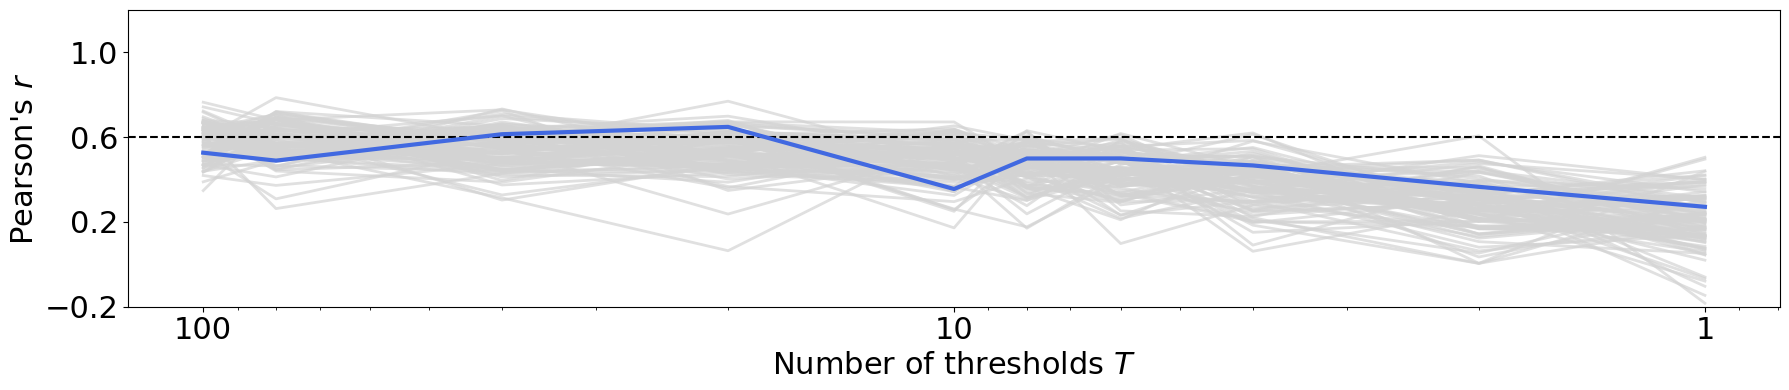

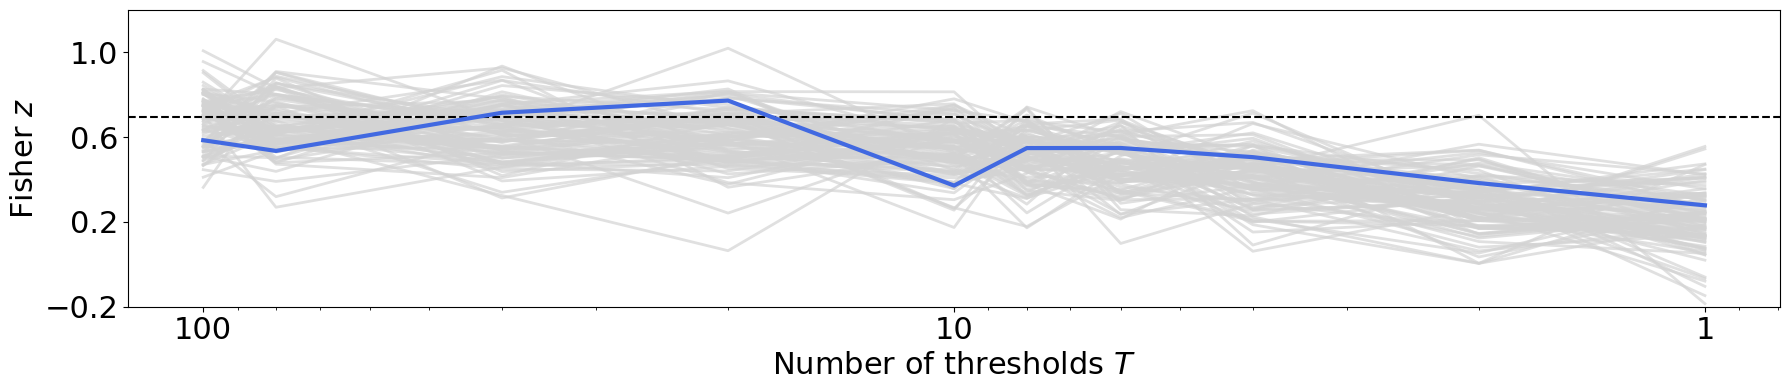

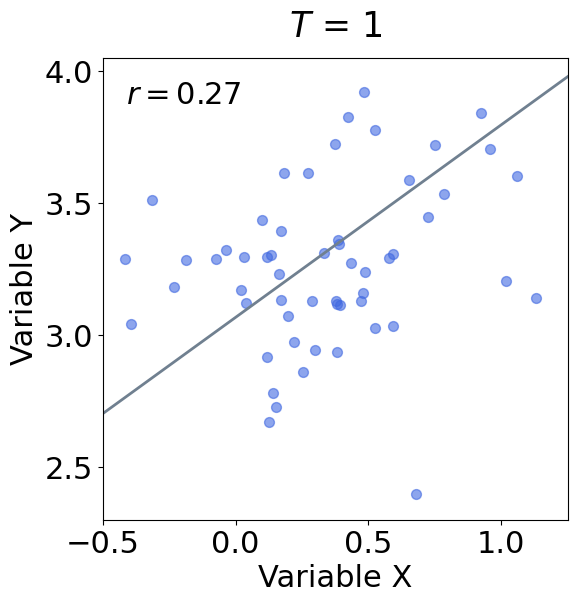

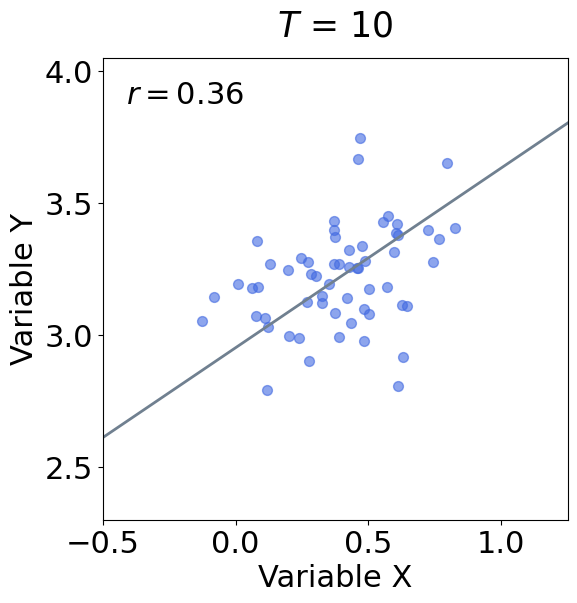

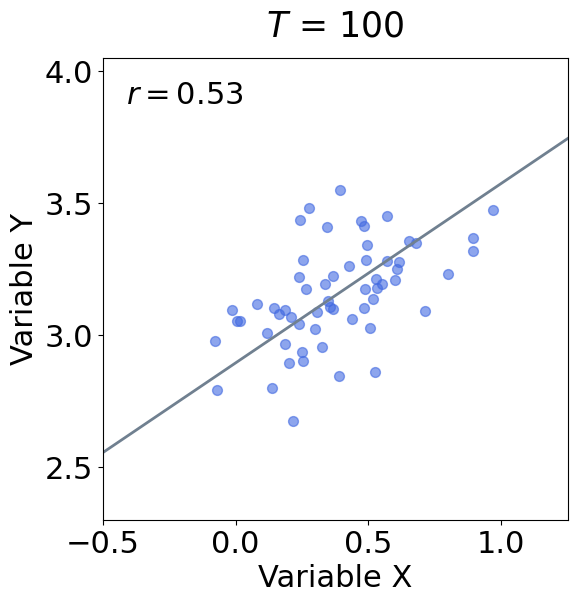

In [48]:
num_thresholds = np.array([1, 2, 4, 6, 8, 10, 20, 40, 80, 100])

simulate_fn = make_simulate_fn_thresholds(mu_x, mu_y, var_x, var_y, rho, n_points=n_points)
measure_fn  = make_measure_fn_thresholds(noise_var=noise_var, m=m)

results, examples = simulate_r_over_sweep(
	num_thresholds,
	simulate_fn=simulate_fn,
	measure_fn=measure_fn,
	example_datasets_points=[1, 10, 100],
	n_traces=100,
	rng=global_rng,
)

plot_traces_with_z(
	num_thresholds,
	results,
	rho=rho,
	xlabel=rf"Number of thresholds $T$",
	true_r=rho,          
	xscale="log",
	ylim=(-0.2, 1.2),
	fontsize=22,
	x_reverse=True

)

for T, x_ex, y_ex in examples:
	plot_scatter_with_tls(x_ex, y_ex, param_legend=rf'$T$ = {T}', rho=rho,
					   xlim=xlim, ylim=ylim)
	plt.show()
